In [1]:
%run ../tools/imports.ipynb
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
h = pickle.load(open("../handler.p", "rb"))#DataHandler(verbose=False, filename='../CAN_whole_nopca.hkl', region='CAN_whole')

def preprocess(X, y, standardization=None):
    
    if standardization is None:
        standardization = [StandardScaler() for i in range(3)]
        fitted = False
    else:
        fitted = True
    
    weather = h.get_weather_from_list(epw_files=X.iloc[:,-1] , n_cols=len(h.columns))

    if fitted:
        weather = standardization[0].transform(weather)
        params = standardization[1].transform(X.iloc[:,:-1])
        y = standardization[2].transform(np.log1p(y))
    else:
        weather = standardization[0].fit_transform(weather)
        params = standardization[1].fit_transform(X.iloc[:,:-1])
        standardization[2].mean_ = np.log1p(y.values).mean().mean()
        standardization[2].scale_ = np.log1p(y.values).ravel().std()
        y = standardization[2].transform(np.log1p(y))
    weather_list=[]
    weather = weather.transpose()
    for i in range(len(X)):
        weather_list.append(weather[:,i*8760:(i+1)*8760].ravel())
    weather = np.array(weather_list)
    
    X = np.hstack((weather, params))
    
    return X, y, standardization

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Couldn't import dot_parser, loading of dot files will not be possible.


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [17]:
!pip install requests
!pip install bs4
!pip install besos
!pip install pvlib
!pip install hickle
!pip install geopandas
!pip install descartes

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from tensorflow.keras.layers import Reshape, Permute, Lambda
import tensorflow as tf


def build_model(lr=0.01):#input_shape, nb_classes):
    n_params=13
    
    n_feature_maps = 64
    
    
    inputs = Input(shape=(8760*17 + n_params), name='inputs')
    #inputs1 = keras.layers.Input(shape=(8760, 10))
    
    weather = Lambda(lambda x: x[:,:8760*17], output_shape=(8760*17), name='weather')(inputs)    
    params = Lambda(lambda x: x[:,-n_params:], output_shape=(n_params), name='params')(inputs)
    
    # BLOCK 1 
    weather = Reshape((17, 8760))(weather)
    weather = Permute((2,1))(weather)
    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(weather)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum 
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(weather)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2 

    conv_x = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum 
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3 

    conv_x = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal 
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL 
    
    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    encoded_weather = keras.layers.Dense(13, activation='relu')(gap_layer)


    
    concat = Concatenate()([encoded_weather, params])
    
    outputs = Dense(30, activation='linear')(concat)
    outputs = LeakyReLU()(outputs)
    outputs = Dense(1, activation='linear')(outputs)
    outputs = LeakyReLU()(outputs)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(lr=lr), loss='mse')
    model.summary()
    
    
    

    #model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), 
    #metrics=['accuracy'])

    #reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

    #file_path = self.output_directory+'best_model.hdf5' 

    #model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss', 
    #    save_best_only=True)

    #self.callbacks = [reduce_lr,model_checkpoint]

    return model

In [11]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, X_raw, y_raw, list_IDs, standardizer, batch_size=32, shuffle=True):
        'Initialization'
        self.X_raw = X_raw
        self.y_raw = y_raw
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.standardizer = standardizer
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X, y,_ = np.array(preprocess(self.X_raw.iloc[list_IDs_temp,:14], self.y_raw.iloc[list_IDs_temp,:], self.standardizer))
        
        y = np.expand_dims(y,2)
        return X, y

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))



    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

In [2]:
X, _ = read_samples('CAN', param_set=23, limit=10000, output_meter = 'DistrictHeating:Facility')
y = pd.DataFrame(np.load('../y_hourly_h.npy'), index=X.index)
#_,_,standardizer = preprocess(X.iloc[0:2000,:14], y.iloc[0:2000, :])

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,:14], y, test_size=0.2, shuffle=True)
del X,y

In [ ]:
import pickle
standardizer2 = pickle.load(open('standarizer.p','rb'))
standardizer[0] = standardizer2[0]
standardizer[1] = standardizer2[1]
#standardizer = pickle.load(open('standardizer_hourly.p','rb'))

In [36]:
pickle.dump(standardizer, open('standardizer_hourly.p','wb'))

In [4]:
standardizer = pickle.load(open('standardizer_hourly.p','rb'))

# set up data generator

In [12]:
training_generator = DataGenerator(X_train, y_train, np.arange(len(X_train), dtype=int), 
                                   standardizer, batch_size=64, shuffle=True)
validation_generator = DataGenerator(X_test, y_test, np.arange(len(X_test), dtype=int), 
                                     standardizer, batch_size=64, shuffle=True)

In [5]:
from tensorflow.keras.layers import Reshape, Permute, Lambda
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open("model_channel64_gpu_100_epochs_3_generator_new.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
ann = model_from_json(loaded_model_json)
# load weights into new model
ann.load_weights("model_channel64_gpu_100_epochs_3_generator_new.h5")
print("Loaded model from disk")

W0121 23:05:36.869458 139753855825728 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0121 23:05:36.871597 139753855825728 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0121 23:05:36.912727 139753855825728 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

Loaded model from disk


In [8]:
%%time

ann.compile(optimizer=Adam(lr=1e-3), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

#ann.fit(X,y,validation_split=0.2,batch_size=64, verbose=1, epochs=100, callbacks=[early_stopping])

ann.fit_generator(generator=training_generator, validation_data=validation_generator, 
                  epochs=150,callbacks=[early_stopping])

Epoch 1/150
124/124 [==============================] - 280s 2s/step - loss: 0.0060 - val_loss: 0.0065
Epoch 2/150
124/124 [==============================] - 266s 2s/step - loss: 0.0058 - val_loss: 0.0080
Epoch 3/150
124/124 [==============================] - 265s 2s/step - loss: 0.0063 - val_loss: 0.0080
Epoch 4/150
124/124 [==============================] - 265s 2s/step - loss: 0.0060 - val_loss: 0.0073
Epoch 5/150
124/124 [==============================] - 266s 2s/step - loss: 0.0062 - val_loss: 0.0121
Epoch 6/150
124/124 [==============================] - 265s 2s/step - loss: 0.0073 - val_loss: 0.0067
Epoch 7/150
124/124 [==============================] - 265s 2s/step - loss: 0.0064 - val_loss: 0.0050
Epoch 8/150
124/124 [==============================] - 265s 2s/step - loss: 0.0060 - val_loss: 0.0084
Epoch 9/150
124/124 [==============================] - 264s 2s/step - loss: 0.0060 - val_loss: 0.0049
Epoch 10/150
124/124 [==============================] - 264s 2s/step - loss: 0.005

# Hourly model

In [6]:
def convert_to_hourly(model):
    inputs = model.input
    
    params = params = Lambda(lambda x: x[:,-13:], output_shape=(13), name='params')(inputs)
    
    
    n_feature_maps=64
    for l in ann.layers:
        l.trainable=False
    
    x = ann.layers[-9].output
    #Concatination block (architecture I)
    params = keras.layers.RepeatVector(8760)(params)
    concat = Concatenate()([x, params])
    concat = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=1, name='conv0_h')(concat)
    concat = keras.layers.Activation('relu', name='act0_h')(concat)
    
    # Block 4 without shortcut to reduce feature map size.
    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same', name='conv1_h')(concat)
    conv_x = keras.layers.BatchNormalization(name='batch1_h')(conv_x)
    
    #ArchitectureII
    #params=keras.layers.Dense(n_feature_maps, activation='linear')(params)
    #params = keras.layers.RepeatVector(8760)(params)
    #conv_x = keras.layers.add([conv_x,params])
    conv_x = keras.layers.Activation('relu', name='act1_h')(conv_x)

    conv_y = keras.layers.Conv1D(filters=32, kernel_size=5, padding='same', name='conv2_h')(conv_x)
    conv_y = keras.layers.BatchNormalization(name='batch2_h')(conv_y)
    conv_y = keras.layers.Activation('relu', name='act2_h')(conv_y)
    
    ##params = Lambda(lambda x: x[-13:], output_shape=(None, 8760,13), name='params_stacked')(inputs)
    # Old Architecture
    #params = keras.layers.RepeatVector(8760)(params)
    #concat = Concatenate()([conv_y, params])
    
    outputs = keras.layers.Conv1D(filters=1, kernel_size=1, padding='same', name='conv3_h')(conv_y) 
    outputs = keras.layers.BatchNormalization(name='batch3_h')(outputs) # not used in old architecture
    outputs = LeakyReLU(name='act3_h')(outputs)
    
    model = Model(inputs, outputs)
    return model

In [8]:
ann_h = convert_to_hourly(ann)
ann_h.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 148933)]     0                                            
__________________________________________________________________________________________________
weather (Lambda)                (None, 148920)       0           inputs[0][0]                     
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 17, 8760)     0           weather[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 8760, 17)     0           reshape_1[0][0]                  
______________________________________________________________________________________________

In [44]:
from tensorflow.keras.layers import Reshape, Permute, Lambda
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open("model_hourly_new_architecture_trainall.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
ann_h = model_from_json(loaded_model_json)
# load weights into new model
ann_h.load_weights("model_hourly_new_architecture_trainall.h5")
print("Loaded model from disk")

Loaded model from disk


In [14]:
%%time

for l in ann_h.layers:
    l.trainable=True


ann_h.compile(optimizer=Adam(lr=1e-1), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#ann.fit(X,y,validation_split=0.2,batch_size=64, verbose=1, epochs=100, callbacks=[early_stopping])

ann_h.fit_generator(generator=training_generator, validation_data=validation_generator, 
                  epochs=5,callbacks=[early_stopping])

Epoch 1/5
124/124 [==============================] - 316s 3s/step - loss: 0.1994 - val_loss: 0.2691
Epoch 2/5
124/124 [==============================] - 300s 2s/step - loss: 0.1020 - val_loss: 0.1339
Epoch 3/5
 28/124 [=====>........................] - ETA: 3:33 - loss: 0.0971

KeyboardInterrupt: 

In [21]:
# serialize model to JSON
model_json = ann_h.to_json()
with open("model_hourly_new_architecture_trainall.json", "w") as json_file:
    #json_file.write(model_json)
# serialize weights to HDF5
#ann_h.save_weights("model_hourly_new_architecture_trainall.h5")

In [15]:
%%time
validation_generator.shuffle=False
y_hat = ann_h.predict_generator(validation_generator)

CPU times: user 23.8 s, sys: 16.6 s, total: 40.4 s
Wall time: 25 s


In [16]:
y_hat = y_hat.squeeze()

In [17]:
y_hat_temp = np.expm1(standardizer[2].inverse_transform(y_hat))

In [18]:
y_hat_temp.shape

(1984, 8760)

In [19]:
r2_score(np.transpose(y_test.values[:len(y_hat_temp),:]), np.transpose(y_hat_temp))

-3.6303235444818833

In [32]:
#y_hat=ann.predict(X)
scores=[]
for ind in range(0,1900):
    scores.append(r2_score(y_test.iloc[ind,:], y_hat_temp[ind,:]))
    #plt.figure()
    #plt.plot(y_test.iloc[ind,:])
    #plt.plot(y_hat_temp[ind,:])

0.8647557156363521


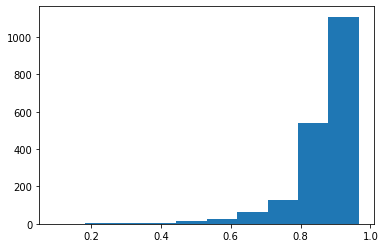

In [33]:
plt.hist(scores)
print(np.mean(scores))

In [20]:
pd.DataFrame(scores).sort_values(0, ascending=False)

NameError: name 'scores' is not defined

-2.538968821787594


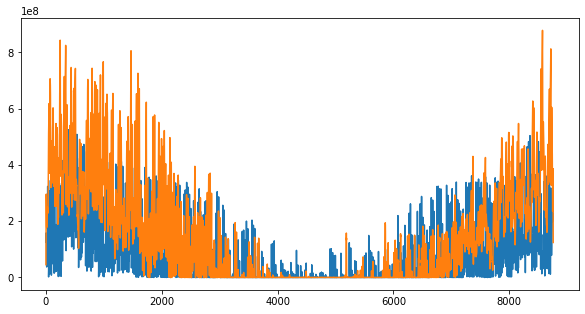

In [28]:
ind=1
plt.figure(figsize=(10,5))
print(r2_score(y_test.iloc[ind,:], y_hat_temp[ind,:]))
plt.plot(y_test.iloc[ind,:])
plt.plot(y_hat_temp[ind,:])

# Visualize layer output

In [6]:
layer_name = -5
intermediate_layer_model = Model(inputs=ann.input,
                                 outputs=[ann.layers[3].output,ann.layers[-9].output,ann.layers[-8].output,ann.layers[-7].output])
intermediate_output = intermediate_layer_model.predict(weather_X)

In [17]:
import seaborn as sns
import matplotlib.animation as animation
import matplotlib
from IPython.display import HTML
from IPython.display import display, Image

In [19]:
matplotlib.rc('animation', html='html5')
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)
cities = weather_df.iloc[:,13:16]
cities = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.longitude, cities.latitude))
cities.crs = {'init' :'epsg:4326'}
canada = gpd.read_file("/home/user/map_data/lpr_000b16a_e.shp").to_crs(epsg=4326)

def animate(i):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(20,6)) 
    ind = i*25
    sns.heatmap(intermediate_output[0][ind,:,:].transpose(), ax=ax1, cmap="RdBu_r", vmin=-5, vmax=5, cbar=False)
    sns.heatmap(intermediate_output[1][ind,:,:].transpose(), ax=ax2, cmap='Blues', vmin=0, vmax=1500, cbar=False)
    sns.heatmap(intermediate_output[2][ind,:].reshape(1,-1).transpose(), ax=ax3, cmap='Blues', vmin=0, vmax=800, cbar=False)
    sns.heatmap(intermediate_output[3][ind,:].reshape(1,-1).transpose(), ax=ax4, cmap='Blues', vmin=0, vmax=1500, cbar=False)
    ax = canada.to_crs(epsg=3573).plot(edgecolor='black', ax=ax5)
    ax = cities.iloc[ind:ind+1,:].to_crs(epsg=3573).plot(ax=ax, markersize=30, color='red', edgecolor='black', linewidth=2)
    plt.suptitle(weather_df.iloc[ind,13])
    #return (p,)
    #p.tick_params(labelsize=17)
    #plt.setp(p.lines,linewidth=7)
    plt.tight_layout()
    plt.savefig(f'Images/test{i}.png')
    plt.close()

#fig = plt.figure()

#ani = animation.FuncAnimation(fig, animate, frames=3, interval=500, blit=True)
#plt.close(ani._fig)
#HTML(ani.to_jshtml())

In [20]:
%%time

for i in range(22):
    animate(i)


CPU times: user 9min 55s, sys: 21.7 s, total: 10min 16s
Wall time: 9min 55s


In [22]:
from PIL import Image
frames = []
for i in range(22):
    frames.append(Image.open(f"Images/test{i}.png"))


# Save into a GIF file that loops forever
frames[0].save('moving_ball_new.gif', format='GIF', append_images=frames[1:], save_all=True, duration=1000, loop=0)

#images[0].save('Images/pillow_imagedraw.gif',
#               save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

In [8]:
np.shape(h.data)

(4993200, 10)

In [9]:
h = DataHandler(verbose=True, region='CAN_whole')

Starting to load 570 epw files.
Loaded  0.18 %
Loaded  0.35 %
Loaded  0.53 %
Loaded  0.70 %
Loaded  0.88 %
Loaded  1.05 %
Loaded  1.23 %
Loaded  1.40 %
Loaded  1.58 %
Loaded  1.75 %
Loaded  1.93 %
Loaded  2.11 %
Loaded  2.28 %
Loaded  2.46 %
Loaded  2.63 %
Loaded  2.81 %
Loaded  2.98 %
Loaded  3.16 %
Loaded  3.33 %
Loaded  3.51 %
Loaded  3.68 %
Loaded  3.86 %
Loaded  4.04 %
Loaded  4.21 %
Loaded  4.39 %
Loaded  4.56 %
Loaded  4.74 %
Loaded  4.91 %
Loaded  5.09 %
Loaded  5.26 %
Loaded  5.44 %
Loaded  5.61 %
Loaded  5.79 %
Loaded  5.96 %
Loaded  6.14 %
Loaded  6.32 %
Loaded  6.49 %
Loaded  6.67 %
Loaded  6.84 %
Loaded  7.02 %
Loaded  7.19 %
Loaded  7.37 %
Loaded  7.54 %
Loaded  7.72 %
Loaded  7.89 %
Loaded  8.07 %
Loaded  8.25 %
Loaded  8.42 %
Loaded  8.60 %
Loaded  8.77 %
Loaded  8.95 %
Loaded  9.12 %
Loaded  9.30 %
Loaded  9.47 %
Loaded  9.65 %
Loaded  9.82 %
Loaded 10.00 %
Loaded 10.18 %
Loaded 10.35 %
Loaded 10.53 %
Loaded 10.70 %
Loaded 10.88 %
Loaded 11.05 %
Loaded 11.23 %
Loaded 1

In [16]:
h.save_data(filename='CAN_whole_nopca.hkl')

In [15]:
np.shape(h.data)

(4993200, 17)